# Improving Numerical Integration Methods

The estimation of Dynamic Discrete Choice Models (DDCM) is often constrained by computational constraints. For example, Keane and Wolpin (1997) and subsequent work that estimates DDCM's of post-graduation career dynamics abstract from many important determinants of earnings and mobility dynamics. Examples include the abstraction from match heterogeneity, permanent skill shocks, and failure to account appropriately for multidimensional skill structures.

Keane and Wolpin (1994, 1997) split their occupational classes into white- and blue-collar occupations. Nevertheless, empirical evidence suggests that skill requirements vary substantially within blue- and white-collar occupations. Arguably any aggregation of occupational classes should be able to account for meaningful skill differences. Acemoglu and Autor (2011) suggest four aggregate groups that are explicitly derived from the task content of classified three digit occupations in US data.[<sup>1</sup>](#fn1)

Adding elements alike enlarges the computational burden of solving a model alike enormously, and as already Keane and Wolpin (1994) noted, "[...] for problems of the size we would like to consider a [...] simulation strategy is not computationally practicable." A primary bottleneck in solving and estimating DDCM's is the solution of the expected value function, the so-called $EMax(\cdot)$, which was usually undertaken by means of a Monte-Carlo simulation. Adding new features to the model increases the required number of function evaluations, which are the costly operation in numerical integration. Results from applied mathematics suggest methods that are more efficient and thus enable a performance increase. For the same number of function evaluations, quasi-Monte Carlo methods achieve a significantly higher accuracy.

With ``respy`` you are able to employ Quasi-Monte Carlo methods to solve and estimate DDCM's. This notebook contains a tutorial on how to specify the numerical integration option in ``respy``. For expositional purposes we will rely on the KW 1994 model. The following sections:

- Will explain how to choose the Monte Carlo Method in respy.
- Provide a Simulation study: How does the integration method affects the solution of the model?
- Will describe how to choose the number of iterations.

The following [slides](https://github.com/HumanCapitalAnalysis/student-project-rafael_suchy/blob/master/slides/numerical_integration_ddcm.pdf) give a gentle introduction into the KW (1994) model and highlight its main components. Additionally the reason and basic intuition for the usage of Monte Carlo and Quasi-Monte Carlo methods are outlined. 


In [30]:
%matplotlib inline

import pandas as pd
import respy as rp
import numpy as np

from auxiliary_figures import *
from auxiliary_integration import *
from time import time
#plt.style.use("../_static/respy.mplstyle")

ModuleNotFoundError: No module named 'auxiliary_figures'

# Numerical Integration in respy

The current functionality of ``respy`` entails two main methods for the numerical approximation of the $EMax(\cdot)$:
-	Monte Carlo Simulation: Chooses points randomly in the domain 
-	Quasi Monte Carlo Simulation: Chooses points from one of the two low-discrepancy sequences
        - Sobol
        - Halton
        
A very short introduction about the nature of low-discrepancy sequences is provided in the following [notebook](https://github.com/HumanCapitalAnalysis/student-project-rafael_suchy/blob/master/notebooks/98_low_discrepancy_sequences_application_integration.ipynb).

Now it is finally time to get our hands on the implementation in ``respy``. The main method affected is ``create_base_draws`` within ``shared.py``, which as the name suggests creates a set of draws from the standard normal distribution. The draws are either drawn randomly (Monte Carlo Simulation) or from low-discrepancy sequences (Quasi-Monte Carlo Simulation). Either of the methods is used to calculate the $EMax(\cdot)$ in the solution *and* the choice probabilities in the maximum likelihood estimation.

## How to choose the Monte Carlo Method in respy.

As mentioned, we will use the KW (1994) model within this tutorial. First, we get the parametrization of the KW(1994) model. For details, you are welcomed to consult the previous tutorials of this readme. 

In [35]:
params, options = rp.get_example_model("kw_94_one", with_data = False)

The set of *options* helps to define the underlying model and characterizes the solution methods as well as some functional forms. Inspecting the content we recognize the relevant options `solution_draws` and `monte_carlo_sequence`. 

In [36]:
options

{'estimation_draws': 200,
 'estimation_seed': 500,
 'estimation_tau': 500,
 'interpolation_points': -1,
 'n_periods': 40,
 'simulation_agents': 1000,
 'simulation_seed': 132,
 'solution_draws': 500,
 'solution_seed': 1,
 'monte_carlo_sequence': 'random',
 'core_state_space_filters': ["period > 0 and exp_{i} == period and lagged_choice_1 != '{i}'",
  "period > 0 and exp_a + exp_b + exp_edu == period and lagged_choice_1 == '{j}'",
  "period > 0 and lagged_choice_1 == 'edu' and exp_edu == 0",
  "lagged_choice_1 == '{k}' and exp_{k} == 0",
  "period == 0 and lagged_choice_1 == '{k}'"],
 'covariates': {'constant': '1',
  'exp_a_square': 'exp_a ** 2',
  'exp_b_square': 'exp_b ** 2',
  'at_least_twelve_exp_edu': 'exp_edu >= 12',
  'not_edu_last_period': "lagged_choice_1 != 'edu'",
  'edu_ten': 'exp_edu == 10'}}

The option `solution_draws` specifies how many points are simulated in order to solve the model. Ceteris paribus, choosing more points leads to a higher accuracy but also to higher computational costs. The option `monte_carlo_sequence` determines the method.[<sup>2</sup>](#fn2) As we will see, the implementation of Quasi-Monte Carlo methods enables to break the trade-off: It is possible to increase the accuracy for a given set of points, switching from Monte Carlo methods to Quasi-Monte Carlo methods.

Currently is is possible to choose `monte_carlo_sequence` from the set of $\{$"random", "halton", "sobol" $\}$. In the following we will use the Sobol sequence with 200 draws to solve the model (`rp.solve`), by changing the option parameters as follows.

In [33]:
options["monte_carlo_sequence"], options["solution_draws"]  = ["sobol", 200]
state_space = rp.solve(params, options)

To verify, we can shortly check whether the options were changed correctly.

In [34]:
options["monte_carlo_sequence"], options["solution_draws"]

('sobol', 200)

Up to this point, the relevant methods for changing the methods are mentioned. Hence, the eager reader can start to experiment with its own model (or a different Keane and Wolping specification). In the next section we will provide an example and simulate the KW(1994) with different options. We will elaborate on how the employed Monte Carlo Methods affects the model.

## Simulation study: How does the integration method affects the solution of the model?

We will simulate the model with either of the methods: "random", "halton", "sobol" and vary the amount of points from `POINTS_MIN` to `POINTS_MAX` by increments of (`POINTS_MAX` -  `POINTS_MIN`)/`NUM_EVALS` that are used in the solution of the model. A reference value is calculated by using a very large amount of points ``POINTS_TRUTH``. Note, solving the whole model with ``POINTS_TRUTH`` repeatedly would not be possible at all. 

In [ ]:
POINTS_TRUTH = 10_000_000   

POINTS_MIN = 100        # minimum number of points
POINTS_MAX = 10_000     # maximum number of points
NUM_EVALS = 100         # number of evaluations
POINTS_GRID = np.linspace(POINTS_MIN, POINTS_MAX, NUM_EVALS, dtype = int)

METHODS = ["random", "halton", "sobol"]

First, we will compute a reference value for the $EMax(\cdot)$ values by using a large amount of points with the "sobol"-sequence. We extract the "true" $EMax(\cdot)$ values into the object `emax_true`.

<center>
    <b>Caution:</b> Execution may take some time.
</center> 

In [ ]:
options["monte_carlo_sequence"], options["solution_draws"]  = ["sobol", POINTS_TRUTH] 

state_space = rp.solve(params, options)
emax_true = state_space.emax_value_functions

Second, we will loop over the methods and the number of points to calculate the $EMax(\cdot)$ for each specification of the model. 

<center>
    <b>Caution:</b> Execution may take even some more time. <br>
    Alternatively, you can load the results from the pre-simulated pickle-files.
</center> 

In [1]:
df_emax_values = pd.DataFrame(index = POINTS_GRID, columns = METHODS)
df_exec_time = pd.DataFrame(index = POINTS_GRID, columns = METHODS)

for method in METHODS:
    options["monte_carlo_sequence"] = method
    print("Current Iteration:", method.capitalize(), ".")
    for points in POINTS_GRID:
        options["solution_draws"] = points
        state_space = rp.solve(params, options)
        df_emax_values.loc[points][method] = state_space.emax_value_functions

NameError: name 'pd' is not defined

---

## How to choose the number of iterations?

Already in 1975 Hoaglin and Andrews set up recommendations how to report results and procedures when performing simulation studies. Hauck and Anderson (1984) surveyed 1,198 papers in five major statistical journals where 216 provided results that were based on simulation. But only 9% of papers that used a simulation study justified the choice of the number of iterations, finding little support for the recommendations by Hoaglin and Andrews.[<sup>3</sup>](#fn3) 

Harwell (2018) provide an update of the survey. The authors survey studies in six statistics journals between 1985 and 2012 and confirm that the use of simulation studies had doubled since 1984. An improvement of reporting standards is not the case: Less than 18 of 371 simulation studies used an experimental design that could be identified. Additionally, 99.9% of the studies relied on a visual analysis, aka. eyeballing, of the results. In this section we will provide some first ideas how to substantiate the number of iterations within (quasi-)Monte Carlo simulations.

### Iterations for Monte Carlo Analysis 

The variance expression of MC methods can guide our calculation of the number of iterations. Suppose we simulate $N$ samples (iterations) then the variance obtained by the MC procedure is approximately given by

$$
    \dfrac{\sigma^2(f)}{N}.
$$

A-priori, the value of $\sigma^2(f)$ is unknown but can be estimated via MC. As in our example with `POINTS_TRUTH` the first step includes a MC analysis with a very large amount of iterations. Having a desired precision $\rho$ in mind, it would be necessary to perform 

$$
    \sqrt{M} \approx \dfrac{\sigma}{\rho}
$$

number of iterations.[<sup>4</sup>](#fn4) 

Another less scientific approach acknowledges the diversity of problems than can be tackled with Monte Carlo simulation. A fixed number of iterations may serve as a guideline and substantiated reasoning for a first implementation. Nevertheless, quantifying extremely small probabilities needs a different amount of iterations than quantifying a mean. Hence, one may wish to manually adjust. Bukaçi et al. (2016) propose a method that is based on convergence plots. As in our example, it is necessary to calculate the value of interest (for example the value of the $EMax(\cdot)$) using different number of iterations. Following Bukaçi et al. (2016) the number of iterations at which the MC method becomes stable can be used in the simulation study.

### Iterations for quasi-Monte Carlo Analysis 

Due to the completely deterministic nature of quasi-Monte Carlo methods (integration) we eventually obtain deterministic, and hence guaranteed error bounds. Theoretically, it is always possible to determine an integration rule that yields a prescribed level of accuracy. To reiterate, with the same computational effort (same number of function evaluations) the quasi-Monte Carlo methods achieve a higher accuracy than the MC method. Hence, having a number of iterations for the Monte Carlo method, we certainly know that employing a quasi-Monte Carlo procedure will perform better. 

Formally we can use the Koksma-Hlawka inequality to determina an error bound of Quasi-Monte Carlo methods.[<sup>5</sup>](#fn5) If the random variable (integrand) $f$ has bounded variance $\mathbb{V}(f)$ on $\bar{I}^d$, then for any $x_1, \dots, x_N \in \bar{I}^d$ we have 

$$
    \left| \dfrac{1}{N} \sum_{i=1}^N f(x_i) - \int_{\bar{I}^d} f(u) \mathrm{d}u ~\right| \leq \mathbb{V}(f) D_N^*(x_1, \dots, x_N),
$$

where $D_N^*$ denotes the star discrepancy[<sup>6</sup>](#fn6) of the nodes.

If all expressions in Koksma-Hlawka inequality can be calculated then specifying a desired precision and solving for the number of iterations $N$ yields the desired result. The world could be so easy if the derivation of the Koksma-Hlawka inequality would not point towards a drawback: it does not apply to functions with simple discontinuities. To circumvent, Brandolini et al. (2013) derive a Koksma-Hlawka-type inequality which applies to piecewise smooth functions. Nevertheless, oftentimes it is not feasible to calculate the expressions directly - in our case it is at least difficult. 

However, the Koksma-Hlawka inequality offers an additional insight: point sets with a small discrepancy guarantee small errors when using quasi-Monte Carlo methods for numerial integration. Number generators based on integer arithmetic module two, as the Sobol-sequence, provide additional equidistribution properties *whenever* the number of iterations $N$ is a power of two, $N = 2^n- 1$. Specifically, our [notebook](https://github.com/HumanCapitalAnalysis/student-project-rafael_suchy/blob/master/notebooks/98_low_discrepancy_sequences_application_integration.ipynb) demonstrates that those sequences are only equidistant, and hence have the minimal star discrepancy, if we have $N = 2^n – 1$ iterations.[<sup>7</sup>](#fn7)





# REST OF ROBINSON FOR REFERENCE

In [1]:
%matplotlib inline

import io
import matplotlib.pyplot as plt
import pandas as pd
import respy as rp
import yaml
import seaborn as sns
import numpy as np

from pathlib import Path
from time import time

plt.style.use("../_static/respy.mplstyle")

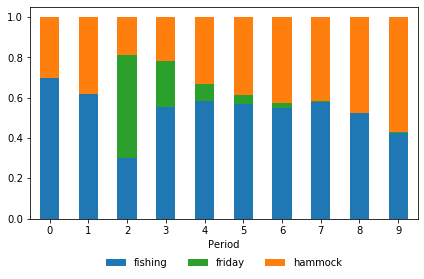

In [17]:
fig, ax = plt.subplots()

df.groupby("Period").Choice.value_counts(normalize=True).unstack().plot.bar(
    stacked=True, ax=ax, color=["C0", "C2", "C1"],
)

plt.xticks(rotation="horizontal")

plt.legend(loc="lower center", bbox_to_anchor=(0.5,-0.275), ncol=3)

plt.show()
plt.close()

## Remarks

<span id="fn1"><sup>1</sup>
    Over the last few decades the empirical literature established a relatively weak economic performance of occupations that require workers to solve routine cognitive or routine manual tasks. Dimensions of occupational skill requirements, skill prices, and employment shares evolved substantially in the last years. As the authors suggest, distinction between   
    $~~~~~$ a) abstract, non-routine tasks (e.g. managerial)   
    $~~~~~$ b) routine cognitive tasks (e.g. adminstrative and sales),   
    $~~~~~$ c) routine manual tasks (e.g. production),    
    $~~~~~$ d) non-routine manual tasks (e.g. service occupations).   
may be more appropriate 
</span>

<span id="fn2"><sup>2</sup>
    Please do not get confused. Although the option name is called `monte_carlo_sequence` it does indeed inlcude the Quasi-Monte Carlo methods. The naming convenation was chosen this way, because in ``respy`` we regard Monte Carlo methods as the aggregate group. 
</span>

<span id="fn3"><sup>3</sup>
    A review of papers within Economics would probably indicate a similar state.   
</span>


<span id="fn4"><sup>4</sup>
    See [Niederreiter (1992)](https://epubs.siam.org/doi/book/10.1137/1.9781611970081) for a thorough treatment including methods for variance reduction.
</span>

<span id="fn5"><sup>5</sup>
    A derivation can be found at pp.19f in [Niederreiter (1992)](https://epubs.siam.org/doi/book/10.1137/1.9781611970081).
</span>


<span id="fn6"><sup>6</sup>
    See[Niederreiter (1992)](https://epubs.siam.org/doi/book/10.1137/1.9781611970081) p.14 for the definition.
</span>

<span id="fn7"><sup>7</sup>
    If 0 is explicitly included in the construction of the sequence then the term “$-1$” can be dropped.
</span>



---
## Appendix: Notation on (quasi-)Monte Carlo approximation

This section will serve as a short introduction into the notation, especially why $f$ can be treated as function (integrand) and as random variable.

For discussion of an approximate calculation of the integral $\int_{\mathbb{D}} f(u) \mathrm{d}u$ we will assume that the integration domain $\mathbb{D} \subseteq \mathbb{R}^d$ satisfies $0 < \lambda_d(\mathbb{D}) < \infty$. We denote the d-dimensional Lebesgue measure with $\lambda_d$. 

By defining the probability meaure $\mathrm{d}\mu = \dfrac{\mathrm{du}}{\lambda_d(\mathbb{D})}$ we turn the domain $\mathbb{D}$ into a probability space. In this notation we can rewrite the integral as 

$$ 
    \int_{\mathbb{D}} f(u) \mathrm{d}u = \lambda_d(\mathbb{D}) f \mathrm{d}\mu = \lambda_d(\mathbb{D}) \mathbb{E}[f], 
$$

where $\mathbb{E}[f]$ denotes the expected value of the random variable $f$.  The Monte Carlo estimate for the expected value $\mathbb{E}[f]$ is obtained by taking $N$ independent $\lambda$-distributed random samples $s_1, \dots, s_N$ from the domain $A$ of the random variable $f$ and let 

$$ 
    \mathbb{E}[f] \approx \dfrac{1}{N} \sum_{i=1}^N f(s_i).
$$

Although this discussion should only introduce some notation we use in the analysis of variance, a derivation (as provided in Niederreiter) shows that we can formalize the Monte Carlo estimate as follows

$$ 
\int_{\mathbb{D}} f(u) \mathrm{d}u \approx \dfrac{1}{N} \sum_{i=1}^N f(y_i),
$$

The nodes $y_i, \dots, y_N$ are $N$ independent random samples from a uniform distribution on $\bar{I}^d$, where $\bar{I}^d$ denotes the closed d-dimensional unit cube. We have a probabilistic error bound of $O(N^{-1/2})$.

The quasi-Monte Carlo approximation looks formally like the MC estimate but is used with deterministic nodes $x_1, \dots, x_N  \in \bar{I}^d$. We take $\mathbb{D}$ as a subset of $\bar{I}^d$ and choose deterministic points $x_1, \dots, x_N \in \mathbb{D}$.  The QMC approximation is given by

$$
\int_\mathbb{D} f(u) \mathrm{d}u \approx \dfrac{1}{N} \sum_{i=1}^N f(x_i).
$$

We get a deterministic error bound of $O(N^{-1}(log(N))^{d-1})$.

---

## References

> Acemoglu, D. and D. Autor (2011). [Skills, Tasks and Technologies: Implications for Employment and Earnings](https://economics.mit.edu/files/7006). *Handbook of Labor Economics*, Chapter 12, Vol. 4b.

> Bukaçi, E. et al. (2016). [Number of iterations needed in Monte Carlo Simulation using reliability analysis for tunnel supports](https://www.ijera.com/papers/Vol6_issue6/Part%20-%203/J0606036064.pdf). *International Journal of Engineering Research and Applications*, 6(6): pp.60-64.

> Brandolini, L., Colzani, L., Gigante, G. and Travaglini, G. (2013). [On the Koksma–Hlawka inequality](https://www.sciencedirect.com/science/article/pii/S0885064X12000854#b000005). *Journal of Complexity*, 29(2): 158-172.

> Hauck, W.H., and Anderson, S. (1984). [A Survey Regarding the Reporting of Simulation Studies](https://amstat.tandfonline.com/doi/abs/10.1080/00031305.1984.10483206#.XjP298hKiUk). *The American Statistician*, 38(3): 214–216.

> Hoaglin, D.C., and Andrews, D.F. (1975). [The Reporting of Computation-Based Results in Statistics](https://www.tandfonline.com/doi/citedby/10.1080/00031305.1975.10477393?scroll=top&needAccess=true). *The American Statistician*, 29(3): 122–126.  

> Harwell, M., Nidhi, K. and Peralta-Torres, Y. (2018). [A Survey of Reporting Practices of Computer Simulation Studies in Statistical Research](https://www.tandfonline.com/doi/full/10.1080/00031305.2017.1342692?scroll=top&needAccess=true). *The American Statistician*, 72(4), pp.321-327.

> Keane, M.P. and Wolpin, K.I. (1997). [The Career Decisions of Young Men](https://doi.org/10.1086/262080). *Journal of Political Economy*, 105(3): 473-522.

> Niederreiter, H. (1992). [Random Number Generation and Quasi-Monte Carlo Methods](https://epubs.siam.org/doi/book/10.1137/1.9781611970081). *CBMS-NSF Regional Conference Series in Applied Mathematics*.


